In [1]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import random

In [2]:
def set_seed(seed):
    random.seed(seed)  # Seed for the random module
    np.random.seed(seed)  # Seed for NumPy
    torch.manual_seed(seed)  # Seed for PyTorch
    torch.cuda.manual_seed(seed)  # Seed for current GPU
    torch.cuda.manual_seed_all(seed)  # Seed for all GPUs (if you have more than one)

# Set the desired seed
set_seed(42)

In [3]:
import os 
file_str="tadv_5min_wave_group_window_15mins_4"
GCN_save_name= os.getcwd() + "/best_GCN_different_group_4_"+file_str +"checkpoint.model.keras"

data=np.load('wave_groups/'+file_str+".npz")
wave_data_train=data["wave_data_train"]
wave_data_test=data["wave_data_test"]
label_train=data["label_train"]
label_test=data["label_test"]
num_classes=2

print(wave_data_train.shape)
print(wave_data_test.shape)

print(label_train.shape)
print(label_test.shape)

(6312, 1152, 1)
(2706, 1152, 1)
(6312,)
(2706,)


In [4]:
# file_str="transformed_data_15_4"
# data=np.load(file_str+".npz")
# transformed_wave_data_train=data["wave_data_train"]
# transformed_wave_data_test=data["wave_data_test"]
# label_train=data["label_train"]
# label_test=data["label_test"]
# num_classes=2

# print(transformed_wave_data_train.shape)
# print(transformed_wave_data_test.shape)

# print(label_train.shape)
# print(label_test.shape)

In [5]:
num_nodes = wave_data_train.shape[1]
num_node_features = wave_data_train.shape[2]

In [6]:
num_neighbours = 70

def create_adjacency_matrix(num_nodes, directionality=True):
    D_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            D_matrix[i,j] = abs(i-j)

    k = num_neighbours
    A = np.zeros_like(D_matrix)
    for i in range(len(A)):
        neighbours = np.argsort(D_matrix[i])[:k]
        if directionality:
            for n in neighbours:
                if n>i:
                    A[i, n] = 0
                else:
                    A[i, n] = 1 
        else:
            A[i, neighbours] = 1 

    return A

In [7]:
import scipy.sparse as sp
import tensorflow as tf

A = create_adjacency_matrix(num_nodes, directionality=False)
sparse_matrix = sp.coo_matrix(A)
indices = np.column_stack((sparse_matrix.nonzero()))
values = sparse_matrix.data
dense_shape = sparse_matrix.shape
sparse_A = tf.SparseTensor(indices=indices, values=values, dense_shape=dense_shape)
print(sparse_A)


SparseTensor(indices=tf.Tensor(
[[   0    0]
 [   0    1]
 [   0    2]
 ...
 [1151 1149]
 [1151 1150]
 [1151 1151]], shape=(80640, 2), dtype=int64), values=tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(80640,), dtype=float64), dense_shape=tf.Tensor([1152 1152], shape=(2,), dtype=int64))


In [8]:
indices = np.column_stack((sparse_matrix.nonzero()))
values = sparse_matrix.data
dense_shape = sparse_matrix.shape
values

array([1., 1., 1., ..., 1., 1., 1.])

In [9]:
file_str="edge_data_15_4_original"

indices = np.column_stack((sparse_matrix.nonzero()))
values = sparse_matrix.data
dense_shape = sparse_matrix.shape

edge_features_train = np.zeros((wave_data_train.shape[0], len(indices)))
edge_features_test = np.zeros((wave_data_test.shape[0], len(indices)))

for i in range(edge_features_train.shape[0]):
    for j in range(len(indices)):
        index = indices[j]
        edge_features_train[i,j] = abs(index[1]-index[0])

for i in range(edge_features_test.shape[0]):
    for j in range(len(indices)):
        index = indices[j]
        edge_features_test[i,j] = abs(index[1]-index[0])

train_min = np.min(edge_features_train)
train_max = np.max(edge_features_train)

test_min = np.min(edge_features_test)
test_max = np.max(edge_features_test)

edge_features_train = (edge_features_train - train_min) / (train_max - train_min)
edge_features_test = (edge_features_test - test_min) / (test_max - test_min)

np.savez(file_str,edge_data_train=edge_features_train, edge_data_test=edge_features_test)

data=np.load(file_str+".npz")
edge_data_train=data["edge_data_train"]
edge_data_test=data["edge_data_test"]

print(edge_data_train.shape)
print(edge_data_test.shape)

(6312, 80640)
(2706, 80640)


In [10]:
file_str="edge_data_15_4_original"
data=np.load(file_str+".npz")
print(data)

NpzFile 'edge_data_15_4_original.npz' with keys: edge_data_train, edge_data_test


In [11]:
file_str="edge_data_15_4_original"
data=np.load(file_str+".npz")
edge_data_train=data["edge_data_train"]
edge_data_test=data["edge_data_test"]

num_classes=2

print(edge_data_train.shape)
print(edge_data_test.shape)

(6312, 80640)
(2706, 80640)


In [12]:
import networkx as nx
# Step 1: Create a graph
G = nx.Graph()

# Step 2: Add edges from the adjacency matrix
adj_matrix_np = A
G = nx.from_numpy_array(adj_matrix_np)

edge_list_train_tensor = np.zeros((edge_data_train.shape[1],3))
edge_list_test_tensor = np.zeros((edge_data_test.shape[1],3))

for i in range(edge_data_train.shape[1]):
    G.add_edge(indices[i][0], indices[i][1], weight = float(edge_data_train[0][i]))
    # edge_list_tensor[i,:1] = sparse_A[i,:]
    # edge_list_tensor[i,2] = edge_data_train[j,i,:]

# Step 4: Add node features as attributes
for i, features in enumerate(wave_data_train[0]):
    G.nodes[i]['features'] = features.tolist()

# Visualize the graph's nodes and edges with their data
# print("Nodes with features:")
# for node, data in G.nodes(data=True):
#     print(f"Node {node}: {data}")

# print("\nEdges with weights:")
# for edge in G.edges(data=True):
#     print(f"Edge {edge}")

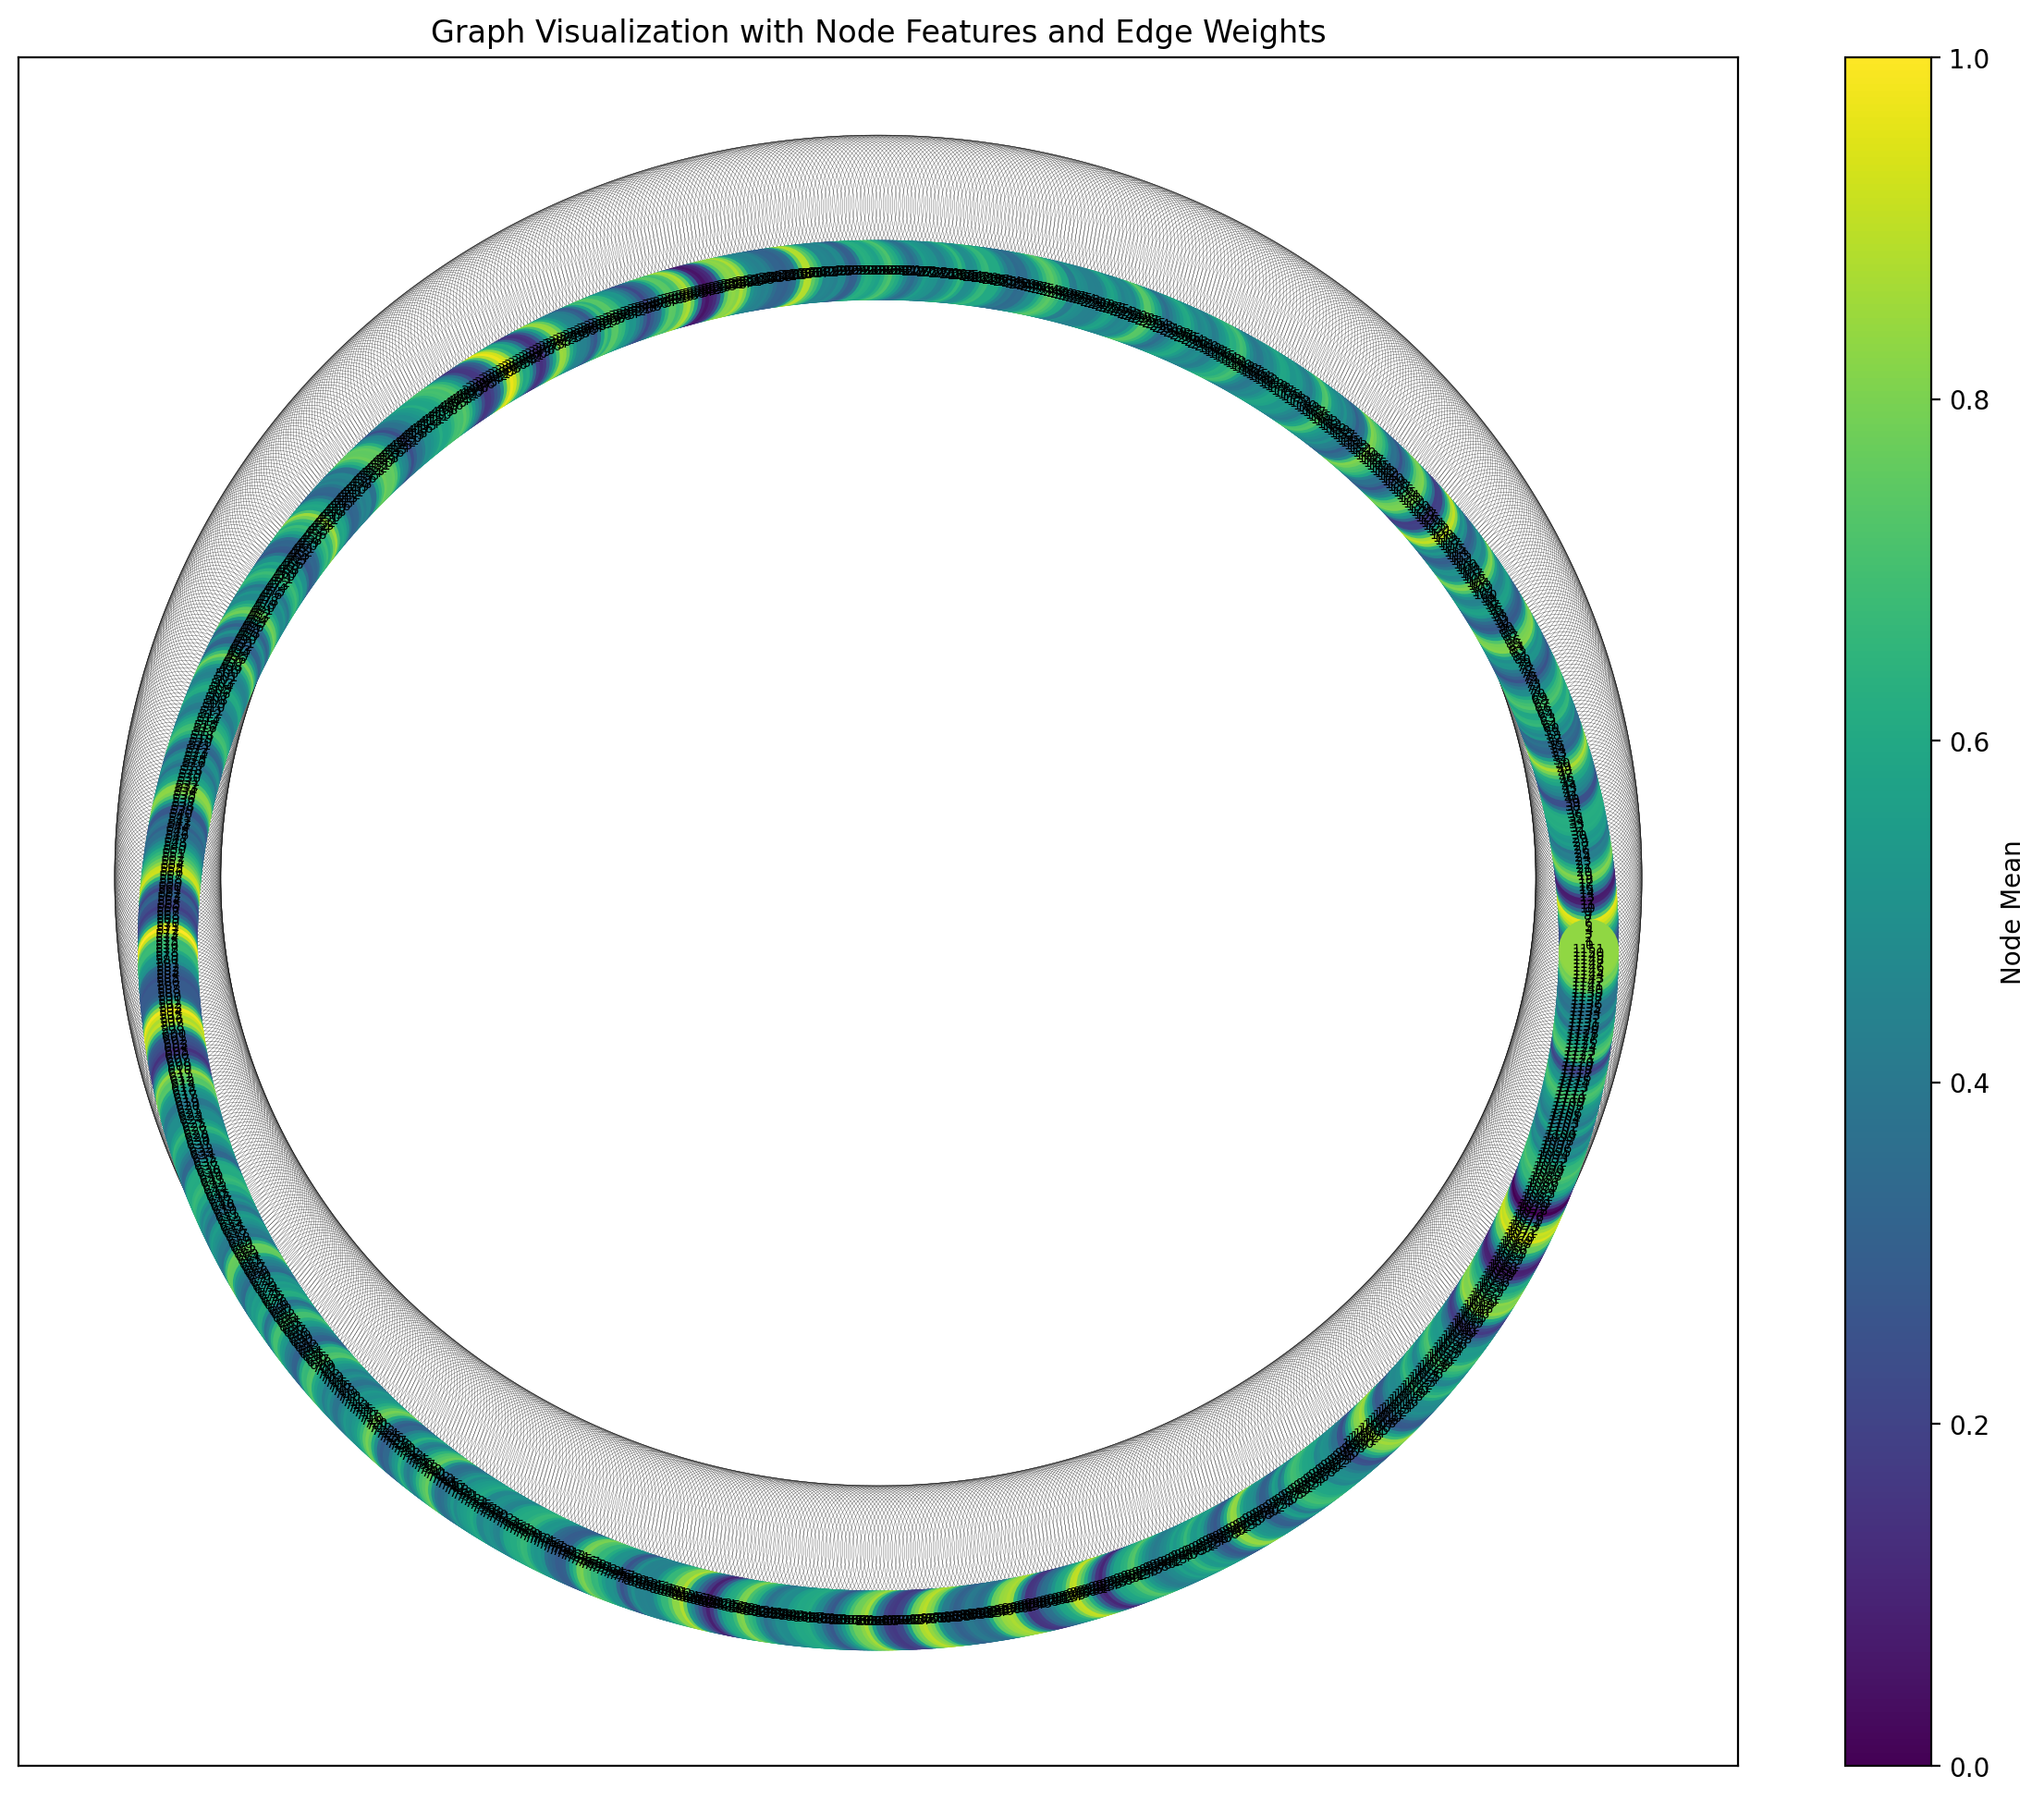

In [16]:
# Visualization
# plt.figure(figsize=(20, 16))
fig, ax = plt.subplots(figsize=(15, 12), dpi=200)

# Draw the graph with node labels
pos = nx.circular_layout(G)  # Spring layout positions nodes naturally

# Draw nodes with color based on feature (just a simple mapping for demo purposes)
node_colors = [G.nodes[node]['features'][0] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.viridis, node_size=500, ax=ax)

## Step 6: Get edge weights for edge thickness
edge_weights = [G.edges[edge]['weight'] for edge in G.edges()]

# Step 7: Normalize edge weights for visualization
# Normalize the edge widths for better visualization (scale weights to a reasonable range)
min_width, max_width = 0.1, 1  # Define the range for edge thickness
normalized_weights = [min_width + (max_width - min_width) * (w - min(edge_weights)) / (max(edge_weights) - min(edge_weights)) for w in edge_weights]

# Step 8: Draw nodes and edges with adjusted edge thickness
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.viridis, node_size=500, ax=ax)
nx.draw_networkx_edges(G, pos, width=normalized_weights, ax=ax)

# Step 9: Draw node labels but omit edge labels
nx.draw_networkx_labels(G, pos, font_size=5, ax=ax)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
# sm.set_array(node_values)  # Add the array for ScalarMappable
fig.colorbar(sm, ax=ax, label="Node Mean")

# plt.show()
# Show plot
plt.title("Graph Visualization with Node Features and Edge Weights")
plt.savefig("Graph visualization_OriginalData.png")
plt.show()

### Creating the graph dataset using graphs for all the examples

In [12]:
# class TimeSeriesGraphDataset(Dataset):
#     def __init__(self, A, E, N, Y, edge_indices):
        
#         self.A = A ## the adjacency matrix for the present scenario
#         self.E = E ## the edge matrix details
#         self.N = N ## the node matrix details
#         self.Y = Y ## the labels used for classification
#         self.edge_indices = edge_indices ## indices for the edge tensor
        
#         self.num_graphs = len(N)

#     def create_graph_dataset(self):
#         graph_dataset = {}
#         graphs = []
#         for k in range(self.num_graphs):
#             G = nx.Graph()
#             G = nx.from_numpy_array(self.A)
#             for i in range(self.E.shape[1]):
#                 G.add_edge(self.indices[i][0], indices[i][1], weight = float(self.E[k][i]))
#             for i, features in enumerate(self.N[k]):
#                 G.nodes[i]['features'] = features.tolist()

#             graphs.append(G)
#         graph_dataset['inputs'] = graphs
#         graph_dataset['labels'] = self.Y
        
#         return graph_dataset

# data_trainVal = TimeSeriesGraphDataset(A, edge_data_train, transformed_wave_data_train, label_train, indices)
# data_test = TimeSeriesGraphDataset(A, edge_data_test, transformed_wave_data_test, label_test, indices)

In [21]:
class GraphDataset(Dataset):
    def __init__(self, graphs, graph_labels=None):
        """
        Args:
            graphs (list): A list of G (networkx graph objects).
            graph_labels (list, optional): A list of graph-level labels.
        """
        self.graphs = graphs
        self.graph_labels = graph_labels

    def __len__(self):
        """Return the number of graphs in the dataset."""
        return len(self.graphs)

    def __getitem__(self, idx):
        """
        Get a single graph from the dataset.

        Args:
            idx (int): Index of the graph to retrieve.
        
        Returns:
            A dictionary containing:
            - 'node_features': Tensor of node features.
            - 'edge_weight': Tensor of edge weights.
            - 'graph_label': (optional) Graph-level label.
        """
        # Get the graph and its attributes
        sample = {}
        G = self.graphs[idx]
        label = self.graph_labels[idx]

        # sample['inputs'] = G
        # sample['outputs'] = label
        
        # Convert NetworkX graph to PyTorch tensors
        edge_index = torch.tensor(list(G.edges)).t().contiguous()  # Transpose for PyTorch geometric compatibility
        edge_weight = torch.tensor([G[u][v]['weight'] for u, v in G.edges()])
        node_features = torch.tensor([G.nodes[node]['features'] for node in G.nodes()])
        batches = torch.full((num_nodes,), idx) 

        # Prepare the output dictionary
        sample = {
            'node_features': node_features,
            'edge_index': edge_index,
            'edge_weight': edge_weight,
            'batch': batches
        }

        # Add graph-level label if available
        if self.graph_labels is not None:
            y = torch.tensor(self.graph_labels[idx]).reshape(1,)
            sample['graph_label'] = y

        # return sample
        return edge_index, node_features, edge_weight, y, batches

In [22]:
def create_graph_dataset_with_labels(adj_matrix, edge_tensor, node_tensor, labels, indices):
    graph_dataset = []
    graph_labels = []
    
    num_graphs = len(node_tensor)
    for k in range(num_graphs):
        G = nx.Graph()
        G = nx.from_numpy_array(adj_matrix)
        for i in range(edge_tensor.shape[1]):
            G.add_edge(indices[i][0], indices[i][1], weight = float(edge_tensor[k][i]))
        for i, features in enumerate(node_tensor[k]):
            G.nodes[i]['features'] = features.tolist()

        # print(k)

        graph_dataset.append(G)
        graph_labels.append(labels[k])

    # 5. Return the dataset
    return GraphDataset(graph_dataset, graph_labels=graph_labels)

In [23]:
# Create the dataset with labels
# trainVal_dataset = create_graph_dataset_with_labels(A, edge_data_train[:10,:], transformed_wave_data_train[:10,:], label_train[:10], indices)

# sample = trainVal_dataset [7]
# print("Node Features:\n", sample['node_features'])
# print("Edge Index:\n", sample['edge_index'])
# print("Edge Weights:\n", sample['edge_weight'])
# print("Graph Label:\n", sample['graph_label'])

In [16]:
# # Create the dataset with labels
# train_val_split = 0.7
# train_dataset = create_graph_dataset_with_labels(A, edge_data_train[:int(train_val_split * len(edge_data_train)),:], transformed_wave_data_train[:int(train_val_split * len(transformed_wave_data_train)),:], label_train[:int(train_val_split * len(label_train))], indices)
# val_dataset = create_graph_dataset_with_labels(A, edge_data_train[int(train_val_split * len(edge_data_train)):,:], transformed_wave_data_train[int(train_val_split * len(transformed_wave_data_train)):,:], label_train[int(train_val_split * len(label_train)):], indices)
# test_dataset = create_graph_dataset_with_labels(A, edge_data_test, transformed_wave_data_test, label_test, indices)

# # Example of accessing the first graph and its labels
# sample = train_dataset[654]
# # print(sample['inputs'].nodes[0]['features'])
# # print(sample['outputs'])
# print("Node Features:\n", sample['node_features'].shape)
# print("Edge Index:\n", sample['edge_index'].shape)
# print("Edge Weights shape:\n", sample['edge_weight'].shape)
# print("Graph Label:\n", sample['graph_label'].shape)
# print("Batch:\n", sample['batch'].shape)

In [ ]:
# Create the dataset with labels
train_val_split = 0.7
train_dataset = create_graph_dataset_with_labels(A, edge_data_train[:int(train_val_split * len(edge_data_train)),:], wave_data_train[:int(train_val_split * len(wave_data_train)),:], label_train[:int(train_val_split * len(label_train))], indices)
val_dataset = create_graph_dataset_with_labels(A, edge_data_train[int(train_val_split * len(edge_data_train)):,:], wave_data_train[int(train_val_split * len(wave_data_train)):,:], label_train[int(train_val_split * len(label_train)):], indices)
test_dataset = create_graph_dataset_with_labels(A, edge_data_test, wave_data_test, label_test, indices)

# Example of accessing the first graph and its labels
edge_indices, x, edge_weights, y, batch = train_dataset[654]

print("Edge Index:\n", edge_indices.shape)
print("Node features:\n", x.shape)
print("Edge Weights shape:\n", edge_weights.shape)
print("Graph Label:\n", y.shape)
print("Batch:\n", batch.shape)

In [18]:
# for i in range(10):
#     graph, label = trainVal_dataset[i]
#     print(label)
#     print(graph.nodes[i]['features'])
#     print(label_train[i])
#     print('\n')

In [19]:
from torch_geometric.loader import DataLoader

In [20]:
print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

Training set   = 4418 graphs
Validation set = 1894 graphs
Test set       = 2706 graphs


In [21]:
# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# print('\nTrain loader:')
# for i, subgraph in enumerate(train_loader):
#     print(f' - Subgraph {i}: {subgraph}')

# print('\nValidation loader:')
# for i, subgraph in enumerate(val_loader):
#     print(f' - Subgraph {i}: {subgraph}')

# print('\nTest loader:')
# for i, subgraph in enumerate(test_loader):
#     print(f' - Subgraph {i}: {subgraph}')

In [22]:
# for data in train_loader:
#     print(data[4][0].shape)

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, Dropout, ReLU, Sigmoid
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.nn import MessagePassing

In [24]:
class WeightedGINConv(MessagePassing):
    def __init__(self, nn, **kwargs):
        super(WeightedGINConv, self).__init__(aggr='add', **kwargs)  # "Add" aggregation.
        self.nn = nn  # Neural network used in the GIN layer (MLP)

    def forward(self, x, edge_index, edge_weight=None):
        # x: Node features [num_nodes, num_features]
        # edge_index: Edge index tensor [2, num_edges]
        # edge_weight: Edge weight tensor [num_edges]
        
        # Message passing step
        return self.propagate(edge_index, x=x, edge_weight=edge_weight)

    def message(self, x_j, edge_weight):
        # x_j: Represents features of the neighboring nodes
        # edge_weight: We multiply the neighboring features by the edge weight
        if edge_weight is None:
            return x_j
        return edge_weight.view(-1, 1) * x_j

    def update(self, aggr_out):
        # Pass the aggregated messages through the MLP (neural network)
        return self.nn(aggr_out)

In [25]:
class GraphIsomorphismNetwork(torch.nn.Module):
    """
    Creates a gnn model based on global pooling of embeddings - for graph level classifications
    """
    def __init__(self, dim_pre_MLP, dim_post_MLP, dim_graphLin, num_pre_layers, num_post_layers, dropout_prob, num_graph_layers, training=True):
        
        self.dim_pre_MLP = dim_pre_MLP
        self.dim_post_MLP = dim_post_MLP
        self.dim_graphLin = dim_graphLin
        self.num_pre_layers = num_pre_layers
        self.num_post_layers = num_post_layers
        self.num_graph_layers = num_graph_layers
        self.dropout_prob = dropout_prob
        self.training = training

        super(GraphIsomorphismNetwork, self).__init__()

        ### Each MLP module has two linear layers, each followed by activation functions of ReLU
        self.MLP = nn.ModuleList()
        for i in range(self.num_pre_layers):
            if i==0:
                mlp_layer = Sequential(Linear(num_node_features, self.dim_pre_MLP), ReLU(), Linear(self.dim_pre_MLP, self.dim_pre_MLP), ReLU()) 
                self.MLP.append(mlp_layer)
            else:
                mlp_layer = Sequential(Linear(self.dim_pre_MLP, self.dim_pre_MLP), ReLU(), Linear(self.dim_pre_MLP, self.dim_pre_MLP), ReLU())
                self.MLP.append(mlp_layer)

        ### The MLP layers is followed by graph convolutional layers
        self.graphLayers = nn.ModuleList()
        for i in range(self.num_graph_layers):
            if i==0:
                if self.training:
                    mlp_layer = Sequential(Linear(self.dim_pre_MLP, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), Dropout(self.dropout_prob), ReLU(), 
                                         Linear(self.dim_graphLin, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), Dropout(self.dropout_prob), ReLU())
                    # gconv_layer = GINConv(mlp_layer)
                    gconv_layer = WeightedGINConv(mlp_layer)
                else:
                    mlp_layer = Sequential(Linear(self.dim_pre_MLP, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), ReLU(), 
                                         Linear(self.dim_graphLin, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), ReLU())
                    # gconv_layer = GINConv(mlp_layer)
                    gconv_layer = WeightedGINConv(mlp_layer)
                
                self.graphLayers.append(gconv_layer)
            else:
                if self.training:
                    mlp_layer = Sequential(Linear(self.dim_graphLin, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), Dropout(self.dropout_prob), ReLU(), 
                                         Linear(self.dim_graphLin, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), Dropout(self.dropout_prob), ReLU())
                    # gconv_layer = GINConv(mlp_layer)
                    gconv_layer = WeightedGINConv(mlp_layer)
                else:
                    mlp_layer = Sequential(Linear(self.dim_graphLin, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), ReLU(), 
                                         Linear(self.dim_graphLin, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), ReLU())
                    # gconv_layer = GINConv(mlp_layer)
                    gconv_layer = WeightedGINConv(mlp_layer)
           
                self.graphLayers.append(gconv_layer)
        
        
        ### The graph convolutional layers are followed by post processing layers
        ### Each MLP module has two linear layers, each followed by activation functions of ReLU
        self.postGCLayers = nn.ModuleList()
        for i in range(self.num_post_layers):
            if i==0 and i!=self.num_post_layers-1:
                if self.training:
                    mlp_layer = Sequential(Linear(self.num_graph_layers*self.dim_graphLin, self.dim_post_MLP), Dropout(self.dropout_prob), ReLU(), 
                                           Linear(self.dim_post_MLP, self.dim_post_MLP), Dropout(self.dropout_prob), ReLU())
                else:
                    mlp_layer = Sequential(Linear(self.num_graph_layers*self.dim_graphLin, self.dim_post_MLP), ReLU(), Linear(self.dim_post_MLP, self.dim_post_MLP), ReLU())
                self.postGCLayers.append(mlp_layer)

            elif i==0 and i==self.num_post_layers-1:
                if self.training:
                    mlp_layer = Sequential(Linear(self.num_graph_layers*self.dim_graphLin, self.dim_post_MLP), Dropout(self.dropout_prob), ReLU(), 
                                           Linear(self.dim_post_MLP, 1), Sigmoid())
                else:
                    mlp_layer = Sequential(Linear(self.num_graph_layers*self.dim_graphLin, self.dim_post_MLP), ReLU(), Linear(self.dim_post_MLP, 1), Sigmoid())
                self.postGCLayers.append(mlp_layer)

            elif i>0 and i<self.num_post_layers-1:
                if self.training:
                    mlp_layer = Sequential(Linear(self.dim_post_MLP, self.dim_post_MLP), Dropout(self.dropout_prob), ReLU(), 
                                           Linear(self.dim_post_MLP, self.dim_post_MLP), Dropout(self.dropout_prob), ReLU())
                else:
                    mlp_layer = Sequential(Linear(self.dim_post_MLP, self.dim_post_MLP), ReLU(), Linear(self.dim_post_MLP, self.dim_post_MLP), ReLU())
                self.postGCLayers.append(mlp_layer)
                
            else:
                if self.training:
                    mlp_layer = Sequential(Linear(self.dim_post_MLP, self.dim_post_MLP), Dropout(self.dropout_prob), ReLU(), 
                                           Linear(self.dim_post_MLP, 1))
                else:
                    mlp_layer = Sequential(Linear(self.dim_post_MLP, self.dim_post_MLP), ReLU(), Linear(self.dim_post_MLP, 1))
                self.postGCLayers.append(mlp_layer)

    def forward(self, x, edge_indices, edge_weights, batch):
        ## Pre-processing layers (MLP modules)
        # print(batch)
        # print(f"The number of unique batches in the batch tensor is {len(torch.unique(batch))}")
        for i in range(self.num_pre_layers):
            x = self.MLP[i](x)

        # print(f"The shape of the input at the end of the pre-processing MLP layers is {x.shape}")
        # print(f"The shape of the the weights fed to the model is {edge_weights.shape}")
        ## Node embeddings
        h = []
        for k in range(self.num_graph_layers):
            x = self.graphLayers[k](x, edge_indices, edge_weights)
            # print(f"The shape of the embedding at the end of the graph layer {k} is {x.shape}")
            h.append(x)

        ## Graph-level pooling
        for k in range(self.num_graph_layers):
            h[k] = global_mean_pool(h[k], batch)
            # print(f"The shape of the embedding after graph level global pooling is {h[0].shape}")

        ## concatenate graph embeddings
        h_concat = torch.cat(h, dim=1)
        # print(f"The shape of the input after concatenating the graph embeddings is {h_concat.shape}")

        ### Post-processing and classification
        for i in range(self.num_post_layers):
            h_concat = self.postGCLayers[i](h_concat)
            # print(f"The shape of the input at the end of the post-processing MLP layer {i} is {h_concat.shape}")

        # print(f"The shape of the input at the end of the post-processing MLP layers is {h_concat.shape}")
        # print(f"The output is:{h_concat}")

        return h_concat

In [26]:
### Hyperparameters to be tested
training = True
dim_pre_MLP = 10
dim_post_MLP = 16
dim_graphLin = 32
num_pre_layers = 1
num_post_layers = 1
dropout_prob = 0.1
num_graph_layers = 3

In [27]:
### File save names
file_str = f"GeneralGNN_dim_pre_MLP_{dim_pre_MLP}"
curves_filename = os.getcwd()+'/training_history_'+'/'+ file_str +'.jpg'
model_filename = os.getcwd()+'/model_saves_'+'/'+ file_str +'.pt'
accuracy_filename = os.getcwd()+'/accuracy_saves_'+'/'+ file_str+'.txt'

In [35]:
def compute_accuracy(preds, labels):
    # print(f"Output:{preds}")
    # print(f"Labels:{labels}")
    predicted_classes = (preds > 0.5).float()
    # print(f"Predicted classes:{predicted_classes}")
    num_correct = (predicted_classes == labels).float().sum()
    print(f"Number of correctly predicted results: {num_correct}")
    print(f"Total number of items: {labels.shape[0]}")
    accuracy = num_correct / labels.shape[0]
    return accuracy.item()

In [36]:
def trainVal(model, dataloader):
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay= 0.001)

    num_epochs = 2

    ##Early stopping parameters
    best_val_loss = float('inf')
    patience = 10
    counter = 0
    best_model_path = model_filename

    ## Keep track of the losses and accuracies over epochs
    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []
    
    for epoch in range(num_epochs+1):
        
        model.train() ## Training mode
        
        train_acc = 0
        train_loss = 0

        for data in dataloader:
            edge_indices = data[0].permute(1,0,2).reshape(data[0].shape[1], data[0].shape[0] * data[0].shape[2])
            node_features = data[1].reshape(data[1].shape[0]*data[1].shape[1], data[1].shape[2]) 
            edge_weights = data[2].reshape(data[2].shape[0]*data[2].shape[1])
            labels = data[3].reshape(data[3].shape[0]*data[3].shape[1],1).float()
            batches = data[4].reshape(data[4].shape[0]*data[4].shape[1])
            num_unique_batches = len(torch.unique(batches))
            batches %= num_unique_batches

            # edge_indices = data[0]
            # node_features = data[1] 
            # edge_weights = data[2]
            # labels = data[3]
            # batches = data[4]

            ## Forward pass
            optimizer.zero_grad()
            output = model(node_features, edge_indices, edge_weights, batches)
            # print(f"Output shape is:{output.shape}")
            loss = criterion(output, labels)

            ## Backward propagation and optimization 
            loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=0.5)
            optimizer.step()

            ## Keep track of the losses and accuracies
            train_loss += loss.item()
            train_acc += compute_accuracy(output, labels)

        # print(f"Dataloader length:{len(dataloader)}")
        # print(f"Train loss: {train_loss}")
        # print(f"Train accuracy: {train_acc}")
        
        epoch_loss = train_loss / len(dataloader)
        epoch_accuracy = train_acc / len(dataloader)

        training_losses.append(epoch_loss)
        training_accuracies.append(epoch_accuracy)

        ## validation
        val_loss = 0.0
        val_acc = 0.0
        
        model.eval()  ## evaluation state
        with torch.no_grad():
            for data in val_loader:
                edge_indices = data[0].permute(1,0,2).reshape(data[0].shape[1], data[0].shape[0] * data[0].shape[2])
                node_features = data[1].reshape(data[1].shape[0]*data[1].shape[1], data[1].shape[2]) 
                edge_weights = data[2].reshape(data[2].shape[0]*data[2].shape[1])
                labels = data[3].reshape(data[3].shape[0]*data[3].shape[1],1).float()
                batches = data[4].reshape(data[4].shape[0]*data[4].shape[1])
                num_unique_batches = len(torch.unique(batches))
                batches %= num_unique_batches

                # edge_indices = data[0]
                # node_features = data[1]
                # edge_weights = data[2]
                # labels = data[3]
                # batches = data[4]
        
                output = model(node_features, edge_indices, edge_weights, batches)
                val_loss += criterion(output, labels).item()
                val_acc += compute_accuracy(output, labels)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        validation_losses.append(val_loss)
        validation_accuracies.append(val_acc)

        ## Put the losses and accuracies in a dictionary which can be returned
        losses = {"Train loss": training_losses,
                  "Train accuracy": training_accuracies,
                  "Validation loss": validation_losses,
                  "Validation accuracy": validation_accuracies}

        ## print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {epoch_loss:.2f}'
              f'| Train Acc: {epoch_accuracy*100:4.3f}% '
              f'| Val Loss: {val_loss:.2f} '
              f'| Val Acc: {val_acc*100: 4.3f}%')

        ### Check for the validation loss improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), best_model_path)
            # print(f'Saving the model with val loss: {val_loss:.4f}')
        else:
            counter +=1

        ### Early stopping condition
        if counter >= patience:
            print("Early stopping triggered.")
            break

    return losses

In [37]:
@torch.no_grad()
def test(model):
    criterion = torch.nn.BCEWithLogitsLoss()
    model.eval()
    test_loss = 0
    test_acc = 0

    for data in test_loader:
        edge_indices = data[0].permute(1,0,2).reshape(data[0].shape[1], data[0].shape[0] * data[0].shape[2])
        node_features = data[1].reshape(data[1].shape[0]*data[1].shape[1], data[1].shape[2]) 
        edge_weights = data[2].reshape(data[2].shape[0]*data[2].shape[1])
        labels = data[3].reshape(data[3].shape[0]*data[3].shape[1],1).float()
        batches = data[4].reshape(data[4].shape[0]*data[4].shape[1])
        num_unique_batches = len(torch.unique(batches))
        batches %= num_unique_batches
        
        output = model(node_features, edge_indices, edge_weights, batches)
        test_loss += criterion(output, labels).item()
        test_acc += compute_accuracy(output, labels)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    return test_loss, test_acc

In [38]:
import time
start_time = time.time()

### Training and evaluation of the model
model = GraphIsomorphismNetwork(dim_pre_MLP, dim_post_MLP, dim_graphLin, num_pre_layers, num_post_layers, dropout_prob, num_graph_layers, training)
train_val_metrics = trainVal(model, train_loader)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time is {elapsed_time / 60:3.2f} minutes.") 

Number of correctly predicted results: 26.0
Total number of items: 64
Number of correctly predicted results: 30.0
Total number of items: 64
Number of correctly predicted results: 30.0
Total number of items: 64
Number of correctly predicted results: 38.0
Total number of items: 64
Number of correctly predicted results: 25.0
Total number of items: 64
Number of correctly predicted results: 31.0
Total number of items: 64
Number of correctly predicted results: 33.0
Total number of items: 64
Number of correctly predicted results: 31.0
Total number of items: 64
Number of correctly predicted results: 32.0
Total number of items: 64
Number of correctly predicted results: 32.0
Total number of items: 64
Number of correctly predicted results: 28.0
Total number of items: 64
Number of correctly predicted results: 36.0
Total number of items: 64
Number of correctly predicted results: 26.0
Total number of items: 64
Number of correctly predicted results: 29.0
Total number of items: 64
Number of correctly 

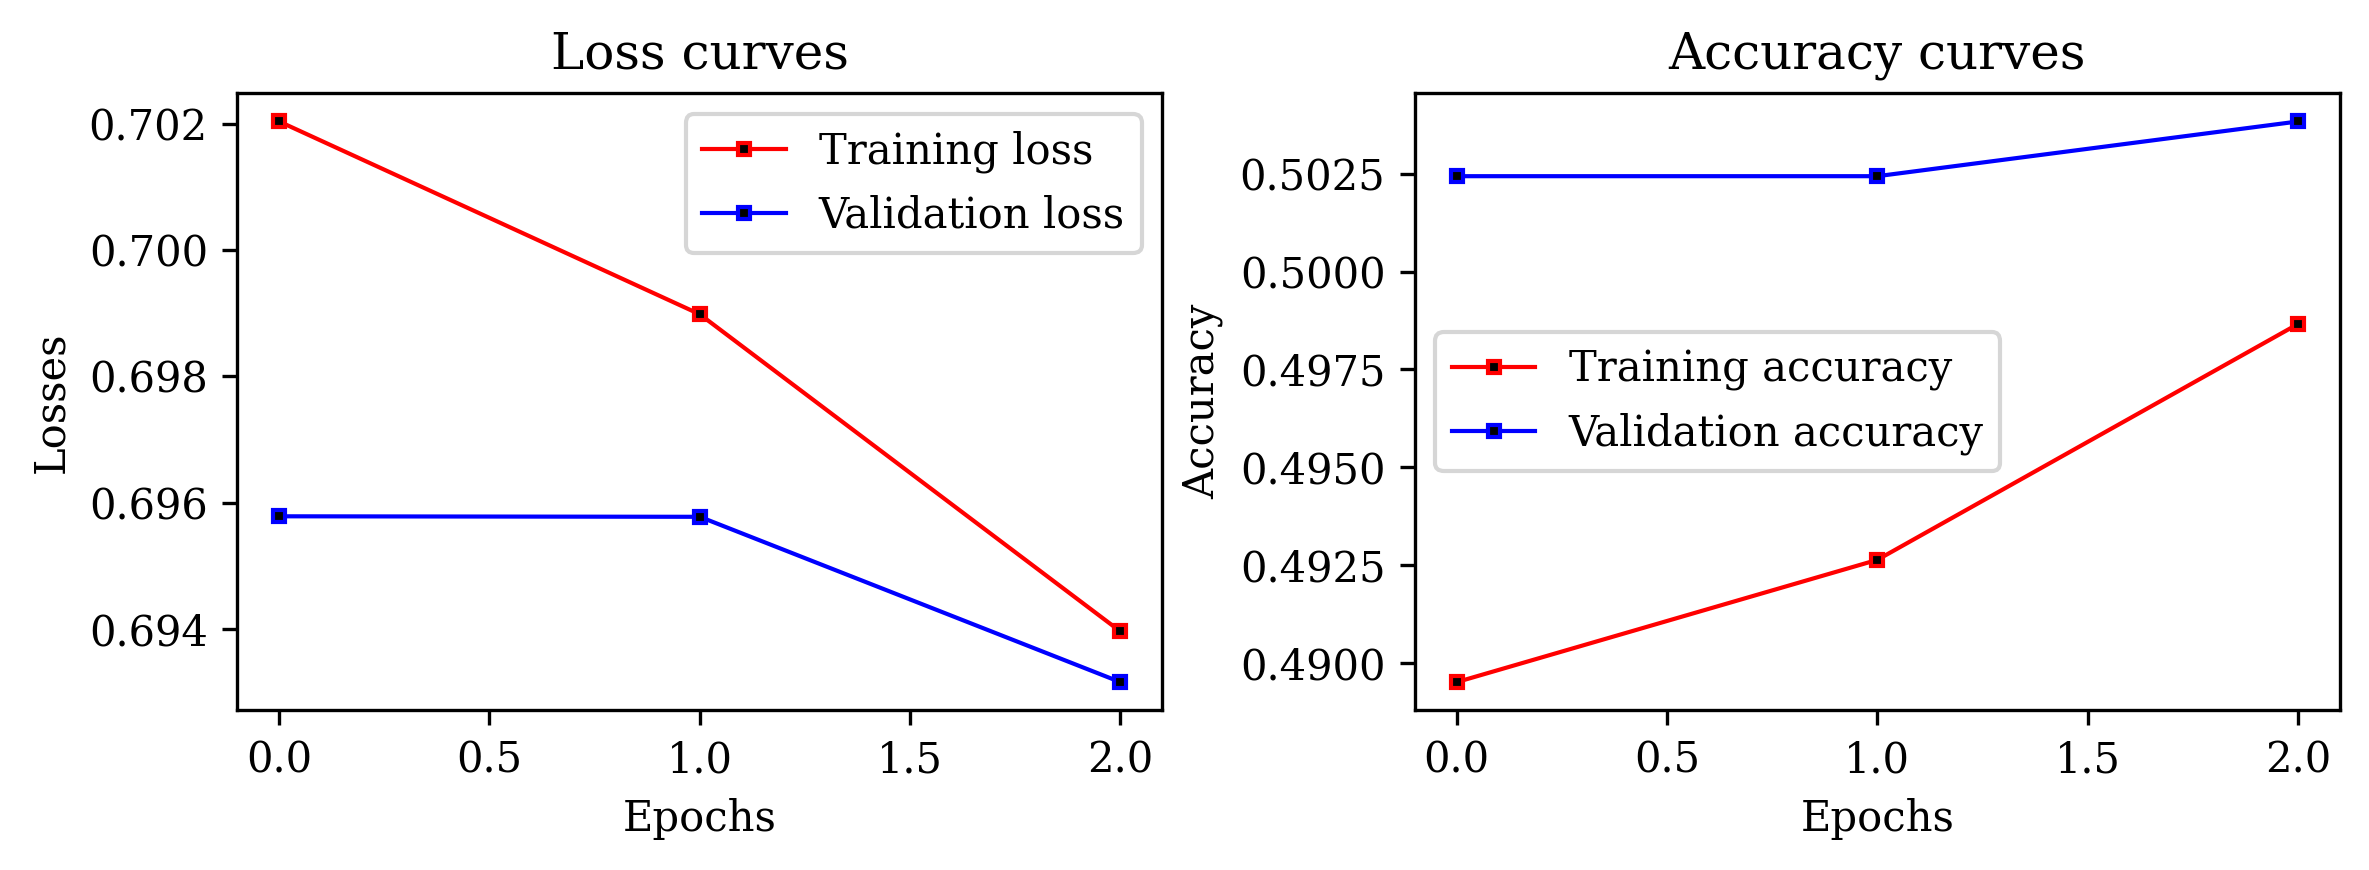

In [39]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"]="serif"
epochs = np.arange(0, len(train_val_metrics["Train loss"]))

fig,ax = plt.subplots(1,2, figsize=[8,3], dpi=300)
ax[0].plot(epochs, train_val_metrics["Train loss"], 'red', linestyle = '-', linewidth=1.0, marker = 's', mfc = 'k', markersize = 3, label = 'Training loss')
ax[0].plot(epochs, train_val_metrics["Validation loss"], 'blue', linestyle = '-', linewidth=1.0, marker = 's', mfc = 'k', markersize = 3, label = 'Validation loss')
ax[0].set_title('Loss curves')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Losses")
ax[0].legend()

ax[1].plot(epochs, train_val_metrics["Train accuracy"], 'red', linestyle = '-', linewidth=1.0, marker = 's', mfc = 'k', markersize = 3, label = 'Training accuracy')
ax[1].plot(epochs, train_val_metrics["Validation accuracy"], 'blue', linestyle = '-', linewidth=1.0, marker = 's', mfc = 'k', markersize = 3, label = 'Validation accuracy')
ax[1].set_title('Accuracy curves')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.tight_layout()
plt.savefig(curves_filename,dpi=199)
# plt.show()

In [40]:
model = GraphIsomorphismNetwork(dim_pre_MLP, dim_post_MLP, dim_graphLin, num_pre_layers, num_post_layers, dropout_prob, num_graph_layers, training=False)
model.load_state_dict(torch.load(model_filename, weights_only=True))
model.eval()

test_metrics = test(model)
formatted_accuracy = "{:.4f}".format(test_metrics[1])
formatted_loss = "{:.4f}".format(test_metrics[0])

print(f"Test loss: {formatted_loss}")
print(f"Test accuracy: {formatted_accuracy}")

Number of correctly predicted results: 35.0
Total number of items: 64
Number of correctly predicted results: 30.0
Total number of items: 64
Number of correctly predicted results: 30.0
Total number of items: 64
Number of correctly predicted results: 37.0
Total number of items: 64
Number of correctly predicted results: 30.0
Total number of items: 64
Number of correctly predicted results: 36.0
Total number of items: 64
Number of correctly predicted results: 29.0
Total number of items: 64
Number of correctly predicted results: 27.0
Total number of items: 64
Number of correctly predicted results: 35.0
Total number of items: 64
Number of correctly predicted results: 32.0
Total number of items: 64
Number of correctly predicted results: 28.0
Total number of items: 64
Number of correctly predicted results: 33.0
Total number of items: 64
Number of correctly predicted results: 32.0
Total number of items: 64
Number of correctly predicted results: 27.0
Total number of items: 64
Number of correctly 

In [41]:
test_loss = test_metrics[0]
test_accuracy = np.array([round(test_metrics[1], 4)])

np.savetxt(accuracy_filename, test_accuracy, fmt='%.4f')